In [1]:
import tensorflow as tf
import os

In [3]:
def load_audio(file_path, sample_rate=44100):
        # Load audio at 44.1kHz sample-rate
        audio = tf.io.read_file(file_path)
        audio, sample_rate = tf.audio.decode_wav\
                             (audio,\
                              desired_channels=-1,\
                              desired_samples=sample_rate)
        return tf.transpose(audio)

In [7]:
prefix = "dataset/data_speech_commands_v0.02"\
            "/zero/"
paths = [os.path.join(prefix, path) for path in \
             os.listdir(prefix)]

Text(0, 0.5, 'Value')

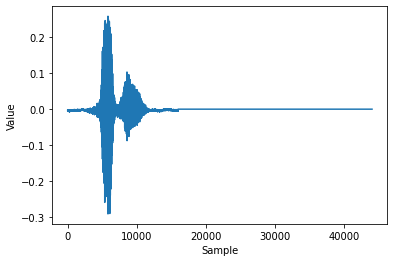

In [8]:
import matplotlib.pyplot as plt
audio = load_audio(paths[0])
plt.plot(audio.numpy().T)
plt.xlabel('Sample')
plt.ylabel('Value')

In [9]:
def apply_mfccs(audio, sample_rate=44100, num_mfccs=13):
        stfts = tf.signal.stft(audio, frame_length=1024, \
                               frame_step=256, \
                               fft_length=1024)
        spectrograms = tf.abs(stfts)
        num_spectrogram_bins = stfts.shape[-1]#.value
        lower_edge_hertz, upper_edge_hertz, \
        num_mel_bins = 80.0, 7600.0, 80
        linear_to_mel_weight_matrix = \
          tf.signal.linear_to_mel_weight_matrix\
          (num_mel_bins, num_spectrogram_bins, \
           sample_rate, lower_edge_hertz, upper_edge_hertz)
        mel_spectrograms = tf.tensordot\
                           (spectrograms, \
                            linear_to_mel_weight_matrix, 1)
        mel_spectrograms.set_shape\
        (spectrograms.shape[:-1].concatenate\
        (linear_to_mel_weight_matrix.shape[-1:]))
        log_mel_spectrograms = tf.math.log\
                               (mel_spectrograms + 1e-6)
        #Compute MFCCs from log_mel_spectrograms
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms\
                (log_mel_spectrograms)[..., :num_mfccs]
        return mfccs

Text(0, 0.5, 'Sample Value')

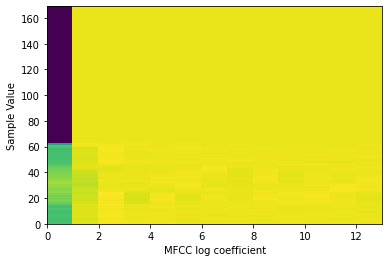

In [10]:
mfcc = apply_mfccs(audio)
plt.pcolor(mfcc.numpy()[0])
plt.xlabel('MFCC log coefficient')
plt.ylabel('Sample Value')

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def prep_ds(ds, shuffle_buffer_size=1024, \
                batch_size=64):
        # Randomly shuffle (file_path, label) dataset
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        # Load and decode audio from file paths
        ds = ds.map(load_audio, num_parallel_calls=AUTOTUNE)
        # generate MFCCs from the audio data
        ds = ds.map(apply_mfccs)
        # Repeat dataset forever
        ds = ds.repeat()
        # Prepare batches
        ds = ds.batch(batch_size)
        # Prefetch
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

In [12]:
ds = tf.data.Dataset.from_tensor_slices(paths)
train_ds = prep_ds(ds)

In [13]:
for x in train_ds.take(1):\
        print(x)

tf.Tensor(
[[[[-7.4533463e+01 -7.9458342e+00  1.2090321e+01 ...  1.5161698e+00
    -2.7944963e+00 -1.6059699e+00]
   [-5.6240124e+01  1.0879500e+00  1.4353226e+01 ...  1.5862125e+00
    -1.8269461e+00  1.6607471e+00]
   [-3.0316593e+01  6.7792544e+00  1.0312693e+01 ... -5.5389804e-01
    -1.7390927e+00  2.1083953e+00]
   ...
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]]]


 [[[-2.3883940e+01 -8.6460991e+00 -2.0435889e+00 ... -4.3643272e-01
     1.0912209e+00 -3.0930877e-01]
   [-2.4277285e+01 -8.1656542e+00 -2.5606477e+00 ... -7.9076874e-01
     2.8335994e-01  1.9360842e-01]
   [-2.4779287e+01 -8.7369385e+00 -2.9124269e+00 ... -1.8598542e-01
     1.0600462e-01  1.2658238e+00]
   ...
   [-1.7475427e+02 -7.8259567e-05  8.2965726